### Datasets
- **American Electric Power (AEP)**: estimated energy consumption in Megawatts (MW)
- **Commonwealth Edison (ComEd)**: estimated energy consumption in Megawatts (MW)
- **The Dayton Power and Light Company**: estimated energy consumption in Megawatts (MW)
- **Duke Energy Ohio/Kentucky (DEOK)**: estimated energy consumption in Megawatts (MW)
- **Dominion Virginia Power (DOM)**: estimated energy consumption in Megawatts (MW)
- **Duquesne Light Co. (DUQ)**: estimated energy consumption in Megawatts (MW)
- **East Kentucky Power Cooperative (EKPC)**: estimated energy consumption in Megawatts (MW)
- **FirstEnergy (FE)**: estimated energy consumption in Megawatts (MW)
- **Northern Illinois Hub (NI)**: estimated energy consumption in Megawatts (MW)
- **PJM East Region: 2001-2018 (PJME)**: estimated energy consumption in Megawatts (MW)
- **PJM West Region: 2001-2018 (PJMW)**: estimated energy consumption in Megawatts (MW)
- **PJM Load Combined: 1998-2001 (PJM_Load)**: estimated energy consumption in Megawatts (MW)

Hacer one hot encoding. Si es de madrid, hacer 0 o 1, y así con cada ciudad

In [14]:
# Importing liabraries
import numpy as np
import pandas as pd
# pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)
import matplotlib.pyplot as plt
import seaborn as sns
import os
import datetime
from prophet import Prophet

# Enable inline plotting
%matplotlib inline

In [15]:
aep=pd.read_csv("../data/AEP_hourly.csv")
comed=pd.read_csv("../data/COMED_hourly.csv")
dayton=pd.read_csv("../data/DAYTON_hourly.csv")
deok=pd.read_csv("../data/DEOK_hourly.csv")
dom=pd.read_csv("../data/DOM_hourly.csv")
duq=pd.read_csv("../data/DUQ_hourly.csv")
ekpc=pd.read_csv("../data/EKPC_hourly.csv")
fe=pd.read_csv("../data/FE_hourly.csv")
ni=pd.read_csv("../data/NI_hourly.csv")
pjme=pd.read_csv("../data/PJME_hourly.csv")
pjmw=pd.read_csv("../data/PJMW_hourly.csv")

## Data preparation AEP

In [56]:
aep.describe()

,y
count,121273.000000
mean,15499.513717
std,2591.399065
min,9581.000000
25%,13630.000000
50%,15310.000000
75%,17200.000000
max,25695.000000


Vemos que los registros van del 2004 al 2018, suficientes datos para realizar un buen modelo de predicción.

In [17]:
data = aep
data.isnull().sum()

Datetime    0
AEP_MW      0
dtype: int64

In [18]:
def kmeansshow(k,X):

    from sklearn import cluster
    from matplotlib import pyplot
    import numpy as np

    kmeans = cluster.KMeans(n_clusters=k)
    kmeans.fit(X)

    labels = kmeans.labels_
    centroids = kmeans.cluster_centers_
    #print centroids

    for i in range(k):
        # select only data observations with cluster label == i
        ds = X[np.where(labels==i)]
        # plot the data observations
        pyplot.plot(ds[:,0],ds[:,1],'o')
        # plot the centroids
        lines = pyplot.plot(centroids[i,0],centroids[i,1],'kx')
        # make the centroid x's bigger
        pyplot.setp(lines,ms=15.0)
        pyplot.setp(lines,mew=2.0)
    pyplot.show()
    return centroids

In [19]:
def split_circular_datetime(df):
    df['year'] = pd.DatetimeIndex(df['Datetime']).year
    df['month'] = pd.DatetimeIndex(df['Datetime']).month
    df['day'] = pd.DatetimeIndex(df['Datetime']).day
    df['hour'] = pd.DatetimeIndex(df['Datetime']).hour

    df['month_x']=np.sin(2.*np.pi*df.month/12.)
    df['month_y']=np.cos(2.*np.pi*df.month/12.)
    df['day_x']=np.sin(2.*np.pi*df.day/31.)
    df['day_y']=np.cos(2.*np.pi*df.day/31.)
    df['hour_x']=np.sin(2.*np.pi*df.hour/24.)
    df['hour_y']=np.cos(2.*np.pi*df.hour/24.)
    return df

In [20]:
data_copy = data.copy()
data_time=split_circular_datetime(data_copy)
data_time

,Datetime,AEP_MW,year,month,day,hour,month_x,month_y,day_x,day_y,hour_x,hour_y
0,2004-12-31 01:00:00,13478.0,2004,12,31,1,-2.449294e-16,1.000000,-2.449294e-16,1.000000,0.258819,0.965926
1,2004-12-31 02:00:00,12865.0,2004,12,31,2,-2.449294e-16,1.000000,-2.449294e-16,1.000000,0.500000,0.866025
2,2004-12-31 03:00:00,12577.0,2004,12,31,3,-2.449294e-16,1.000000,-2.449294e-16,1.000000,0.707107,0.707107
3,2004-12-31 04:00:00,12517.0,2004,12,31,4,-2.449294e-16,1.000000,-2.449294e-16,1.000000,0.866025,0.500000
4,2004-12-31 05:00:00,12670.0,2004,12,31,5,-2.449294e-16,1.000000,-2.449294e-16,1.000000,0.965926,0.258819
...,...,...,...,...,...,...,...,...,...,...,...,...
121268,2018-01-01 20:00:00,21089.0,2018,1,1,20,5.000000e-01,0.866025,2.012985e-01,0.979530,-0.866025,0.500000
121269,2018-01-01 21:00:00,20999.0,2018,1,1,21,5.000000e-01,0.866025,2.012985e-01,0.979530,-0.707107,0.707107
121270,2018-01-01 22:00:00,20820.0,2018,1,1,22,5.000000e-01,0.866025,2.012985e-01,0.979530,-0.500000,0.866025
121271,2018-01-01 23:00:00,20415.0,2018,1,1,23,5.000000e-01,0.866025,2.012985e-01,0.979530,-0.258819,0.965926


c:\Users\alvar\anaconda3\envs\asiot\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


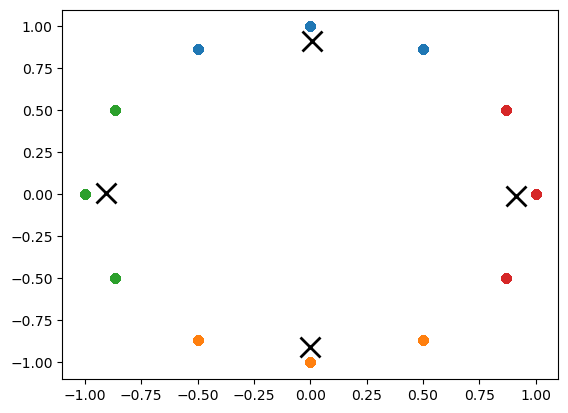

c:\Users\alvar\anaconda3\envs\asiot\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


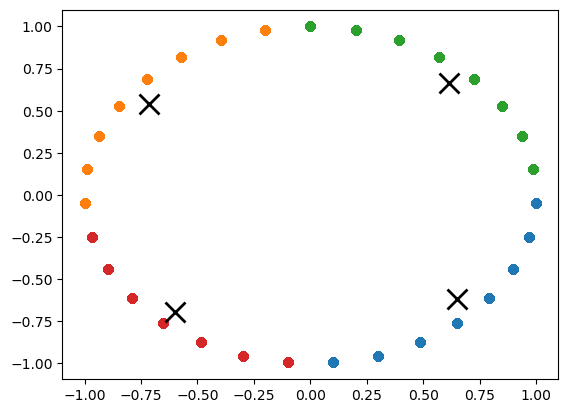

c:\Users\alvar\anaconda3\envs\asiot\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


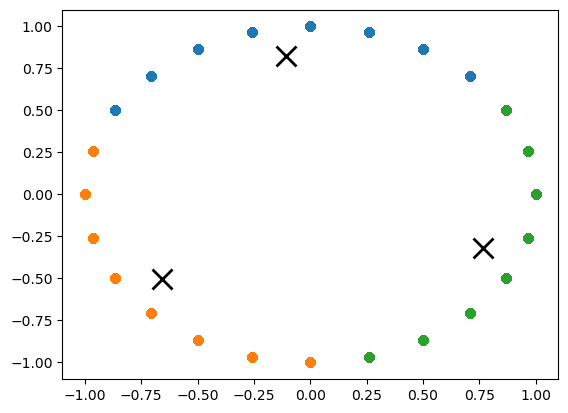

array([[-0.10862864,  0.8222935 ],
       [-0.65797927, -0.50487332],
       [ 0.76622607, -0.31740247]])

In [21]:
kmeansshow(4,data_time[["month_x","month_y"]].values)
kmeansshow(4,data_time[["day_x","day_y"]].values)
kmeansshow(3,data_time[['hour_x', 'hour_y']].values)
# kmeansshow(6,data_time[['hour_x', 'hour_y',"month_x","month_y","day_x","day_y"]].values)

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


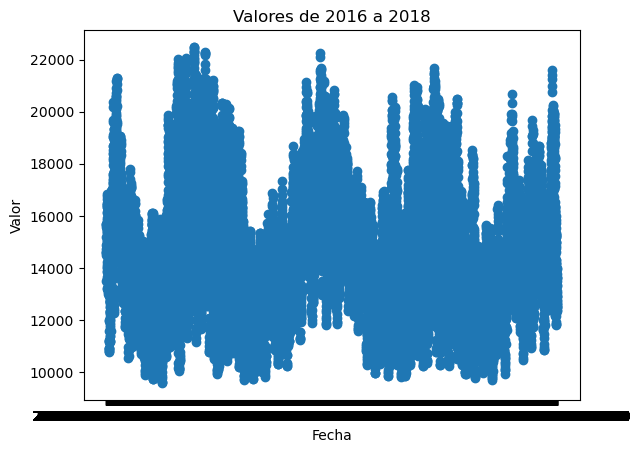

In [55]:
df = aep
df.rename(columns={'Datetime': 'ds', 'AEP_MW': 'y'}, inplace=True)

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

date=df["ds"]
value=df["y"]

mascara = (date >= '2016') & (date <= '2018')

plt.plot_date(date[mascara], value[mascara])

plt.title('Valores de 2016 a 2018')
plt.xlabel('Fecha')
plt.ylabel('Valor')
plt.show()

## Prophet

Rquirements:

- create a new Anaconda environment
- conda install -c conda-forge prophet
- if there are problems: # pip install ipywidgets widgetsnbextension pandas-profiling


In [35]:
df = aep.copy()

In [36]:
df.rename(columns={'Datetime': 'ds', 'AEP_MW': 'y'}, inplace=True)
df

,ds,y
0,2004-12-31 01:00:00,13478.0
1,2004-12-31 02:00:00,12865.0
2,2004-12-31 03:00:00,12577.0
3,2004-12-31 04:00:00,12517.0
4,2004-12-31 05:00:00,12670.0
...,...,...
121268,2018-01-01 20:00:00,21089.0
121269,2018-01-01 21:00:00,20999.0
121270,2018-01-01 22:00:00,20820.0
121271,2018-01-01 23:00:00,20415.0


<AxesSubplot:xlabel='ds'>

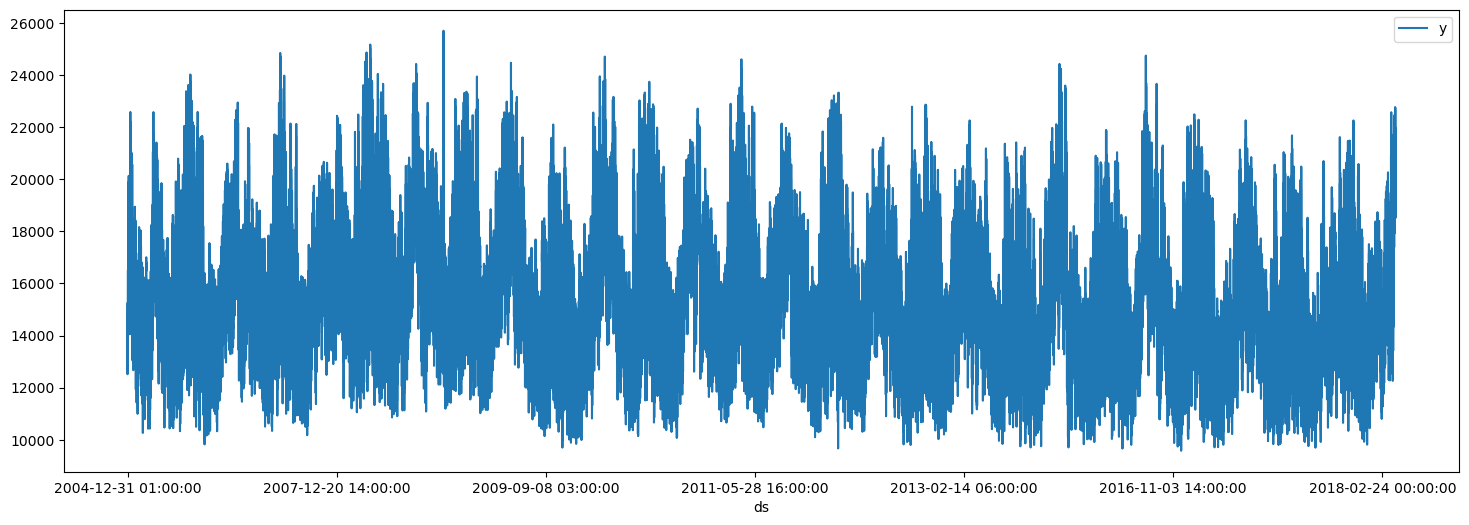

In [37]:
df.plot(x="ds",y="y",figsize=(18,6))

Split the data into train and test:

In [38]:
from sklearn.model_selection import train_test_split
dfcopy=df.copy()
train,test=train_test_split(dfcopy,train_size=0.8,test_size=0.2,random_state=1234, shuffle=False)

Model creation

In [39]:
m = Prophet()
m.fit(train)

c:\Users\alvar\anaconda3\envs\asiot\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Save the model

In [53]:
import joblib 
joblib.dump(m, 'prophet_model.pkl') # Guardo el modelo.

['prophet_model.pkl']